# Inverse vectors and matrices

In this tutorial we will learn how to calculate the element-wise inverse of a tensor train, but also the
inverse of a linear operator.

In [1]:
import numpy as np
from trainsum.numpy import trainsum as ts
import matplotlib.pyplot as plt

In [2]:
dim = ts.dimension(2**10)
domain = ts.domain(-10.0, 10.0)
grid = ts.uniform_grid(dim, domain)

vec_shape = ts.trainshape(dim.size())
vec_shape.ranks = 15
op_shape = ts.trainshape(dim.size(), dim.size(), mode="interleaved")

At the beginning we introduce the problem settings.

In [3]:
# define the Laplace operator as matrix
with ts.exact():
    laplace  = -2.0 * ts.shift(dim, 0)
    laplace +=  1.0 * ts.shift(dim, -1)
    laplace +=  1.0 * ts.shift(dim, 1)
    laplace /= grid.spacings[0]**2
laplace_map = ts.linear_map("ij,jk->ik", laplace, op_shape)

As the next step we create the 1D-Laplace operator as our choice of an invertible square matrix.
The linear map is the matrix multiplication of our operator and the guess.

In [4]:
# define the identity as result
rhs = ts.shift(dim, 0)

# create the linear solver
strat = ts.sweeping_strategy(ncores=2, nsweeps=15)
decomp = ts.svdecomposition(max_rank=16, cutoff=0)
solver = ts.gmres(nsteps=25, subspace=25, eps=1e-10)

lin_solver = ts.linsolver(
    rhs,
    laplace_map,
    strategy=strat,
    decomposition=decomp,
    solver=solver,
    method="dmrg")

Here we define our right hand side of the linear equation as the identity operator and the linear solver.

In [5]:
# callback for printing and retrieval of local results
def callback(lrange, res):
    print(f"{res.residuals[-1]:.8E}", end="\r", flush=True)
    return False

# create some start guess and solve the system
guess = ts.shift(dim, 0)
inv_laplace = lin_solver(guess, callback=callback)
print()

# check trace of the result
res = ts.einsum("ij,jk->", laplace, inv_laplace)
print(res / dim.size())

9.82526465E-11
1.0000000001018634


With the guess defined as the identity operator we can start the solving process.
After that we can check the sum of the matrix multiplication.

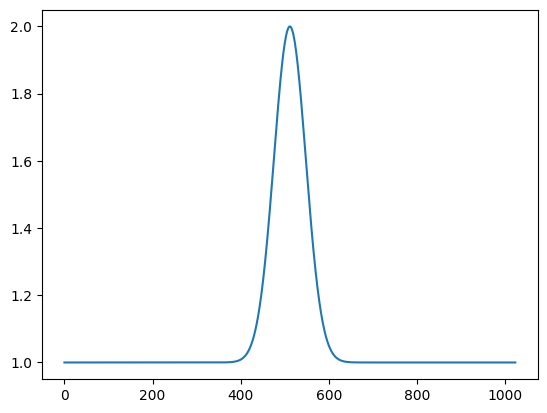

In [6]:
# approximate some data and define it as linear map (essentially its a diagonal matrix)
data = np.exp(-np.linspace(domain.lower, domain.upper, dim.size())**2) + 1
with ts.variational(max_rank=8, cutoff=1e-10, ncores=2, nsweeps=2):
    vec = ts.tensortrain(vec_shape, data)
lin_map = ts.linear_map("i,i->i", vec, vec_shape)

plt.figure()
plt.plot(vec.to_tensor())
plt.show()

Having seen how a matrix can be inverted we will see a element-wise inversion of a Gaussian-shaped function.
We therefore approximate the data variationally and define the linear map for the inversion.

In [7]:
# define the right side as ones
rhs = ts.full(vec_shape, 1.0)

# create the linear solver
strat = ts.sweeping_strategy(ncores=1, nsweeps=5)
decomp = ts.svdecomposition(max_rank=2, cutoff=0)
solver = ts.gmres(nsteps=25, subspace=25, eps=1e-10)

lin_solver = ts.linsolver(
    rhs,
    lin_map,
    strategy=strat,
    decomposition=decomp,
    solver=solver,
    method="amen")

We define the right part of the equation as a vector of ones and define out linear solver.

In [8]:
# callback for printing and retrieval of local results
def callback(lrange, res):
    print(f"{res.residuals[-1]:.8E}", end="\r", flush=True)
    return False
    
# create some start guess and solve the system
guess = ts.full(vec_shape, 0.0)
guess = lin_solver(guess, callback=callback)

7.69527307E-13

Defining the guess as a vector with ones, we can start the linear solver.

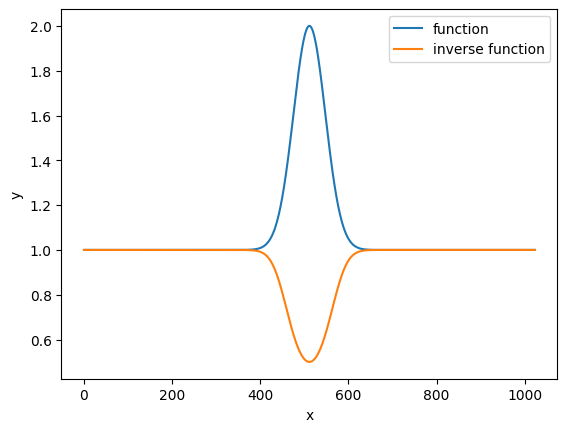

In [9]:
# plot the input function and its inverse
plt.figure()
plt.plot(vec.to_tensor(), label="function")
plt.plot(guess.to_tensor(), label="inverse function")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()